# Gradient Boosting Algorithm with Different Categorical Encoding Strategy

In this example, we will compare the training times and prediction performances of HistGradientBoostingRegressor with different encoding strategies for categorical features. In particular, we will evaluate:

dropping the categorical features

using a OneHotEncoder

using an OrdinalEncoder and treat categories as ordered, equidistant quantities

using an OrdinalEncoder and rely on the native category support of the HistGradientBoostingRegressor estimator.




# 1. Load the dataset

In [1]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml(data_id=42165, as_frame=True, return_X_y=True)

In [3]:
X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [4]:
X.shape

(1460, 80)

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
y.head()

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000


In [8]:
# Select only a subset of features of X to make the example faster to run
categorical_columns_subset = [
    "BldgType",
    "GarageFinish",
    "LotConfig",
    "Functional",
    "MasVnrType",
    "HouseStyle",
    "FireplaceQu",
    "ExterCond",
    "ExterQual",
    "PoolQC",
]

numerical_columns_subset = [
    "3SsnPorch",
    "Fireplaces",
    "BsmtHalfBath",
    "HalfBath",
    "GarageCars",
    "TotRmsAbvGrd",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "GrLivArea",
    "ScreenPorch",
]

In [9]:
X = X[categorical_columns_subset + numerical_columns_subset]
X[categorical_columns_subset] = X[categorical_columns_subset].astype("category")

<ipython-input-9-0438e9dd15ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_columns_subset] = X[categorical_columns_subset].astype("category")


In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   BldgType      1460 non-null   category
 1   GarageFinish  1379 non-null   category
 2   LotConfig     1460 non-null   category
 3   Functional    1460 non-null   category
 4   MasVnrType    1452 non-null   category
 5   HouseStyle    1460 non-null   category
 6   FireplaceQu   770 non-null    category
 7   ExterCond     1460 non-null   category
 8   ExterQual     1460 non-null   category
 9   PoolQC        7 non-null      category
 10  3SsnPorch     1460 non-null   int64   
 11  Fireplaces    1460 non-null   int64   
 12  BsmtHalfBath  1460 non-null   int64   
 13  HalfBath      1460 non-null   int64   
 14  GarageCars    1460 non-null   int64   
 15  TotRmsAbvGrd  1460 non-null   int64   
 16  BsmtFinSF1    1460 non-null   int64   
 17  BsmtFinSF2    1460 non-null   int64   
 18  GrLivAre

In [11]:
categorical_columns = X.select_dtypes(include="category").columns
n_categorical_features = len(categorical_columns)
n_numerical_features = X.select_dtypes(include="number").shape[1]

print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of categorical features: {n_categorical_features}")
print(f"Number of numerical features: {n_numerical_features}")

Number of samples: 1460
Number of features: 20
Number of categorical features: 10
Number of numerical features: 10


# 2. Scenario 1 : Gradient boosting estimator with dropped categorical features

In [12]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline

dropper = make_column_transformer(
    ("drop", make_column_selector(dtype_include="category")), remainder="passthrough"
)
hist_dropped = make_pipeline(dropper, HistGradientBoostingRegressor(random_state=42))

In [13]:
hist_dropped

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x793dd9b0e170>)])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(random_state=42))])

# 3. Scenario 2 : Gradient boosting estimator with one-hot encoding

we create a pipeline that will one-hot encode the categorical features and let the rest of the numerical data to passthrough

In [14]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

hist_one_hot = make_pipeline(
    one_hot_encoder, HistGradientBoostingRegressor(random_state=42)
)

In [15]:
hist_one_hot

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x793dd863fcd0>)])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(random_state=42))])

# 4. Scenario 3 : Gradient boosting estimator with ordinal encoding

we create a pipeline that will treat categorical features as if they were ordered quantities, i.e. the categories will be encoded as 0, 1, 2, etc., and treated as continuous features.

In [16]:
import numpy as np

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
    # Use short feature names to make it easier to specify the categorical
    # variables in the HistGradientBoostingRegressor in the next step
    # of the pipeline.
    verbose_feature_names_out=False,
)

hist_ordinal = make_pipeline(
    ordinal_encoder, HistGradientBoostingRegressor(random_state=42)
)

In [17]:
hist_ordinal

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x793dd86ba050>)],
                                   verbose_feature_names_out=False)),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(random_state=42))])

# 5. Scenario 4 : Gradient boosting estimator with native categorical support

We now create a HistGradientBoostingRegressor estimator that will natively handle categorical features. This estimator will not treat categorical features as ordered quantities. We set categorical_features="from_dtype" such that features with categorical dtype are considered categorical features.

The main difference between this estimator and the previous one is that in this one, we let the HistGradientBoostingRegressor detect which features are categorical from the DataFrame columns’ dtypes.

In [18]:
hist_native = HistGradientBoostingRegressor(
    random_state=42, categorical_features="from_dtype"
)

In [19]:
hist_native

HistGradientBoostingRegressor(categorical_features='from_dtype',
                              random_state=42)

# 6. Model comparison

Finally, we evaluate the models using cross validation. Here we compare the models performance in terms of mean_absolute_percentage_error and fit times.

In [20]:
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate

scoring = "neg_mean_absolute_percentage_error"
n_cv_folds = 3

dropped_result = cross_validate(hist_dropped, X, y, cv=n_cv_folds, scoring=scoring)
one_hot_result = cross_validate(hist_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
ordinal_result = cross_validate(hist_ordinal, X, y, cv=n_cv_folds, scoring=scoring)
native_result = cross_validate(hist_native, X, y, cv=n_cv_folds, scoring=scoring)

In [22]:
print(dropped_result)
print(one_hot_result)
print(ordinal_result)
print(native_result)

{'fit_time': array([0.82302761, 0.75142384, 0.37175894]), 'score_time': array([0.02257705, 0.01421762, 0.01333404]), 'test_score': array([-0.15431253, -0.16431365, -0.15761001])}
{'fit_time': array([0.62425542, 0.65937448, 0.65275931]), 'score_time': array([0.02172732, 0.02282286, 0.0243082 ]), 'test_score': array([-0.1293256 , -0.13360408, -0.12262743])}
{'fit_time': array([0.4450357 , 0.29614091, 0.28598022]), 'score_time': array([0.02313042, 0.0170598 , 0.01678848]), 'test_score': array([-0.12558041, -0.13463241, -0.12361224])}
{'fit_time': array([0.28896761, 0.28241611, 0.29643083]), 'score_time': array([0.01888752, 0.01929045, 0.01972723]), 'test_score': array([-0.12370111, -0.13220487, -0.121861  ])}


# 7. Visualize performance of different scenarios

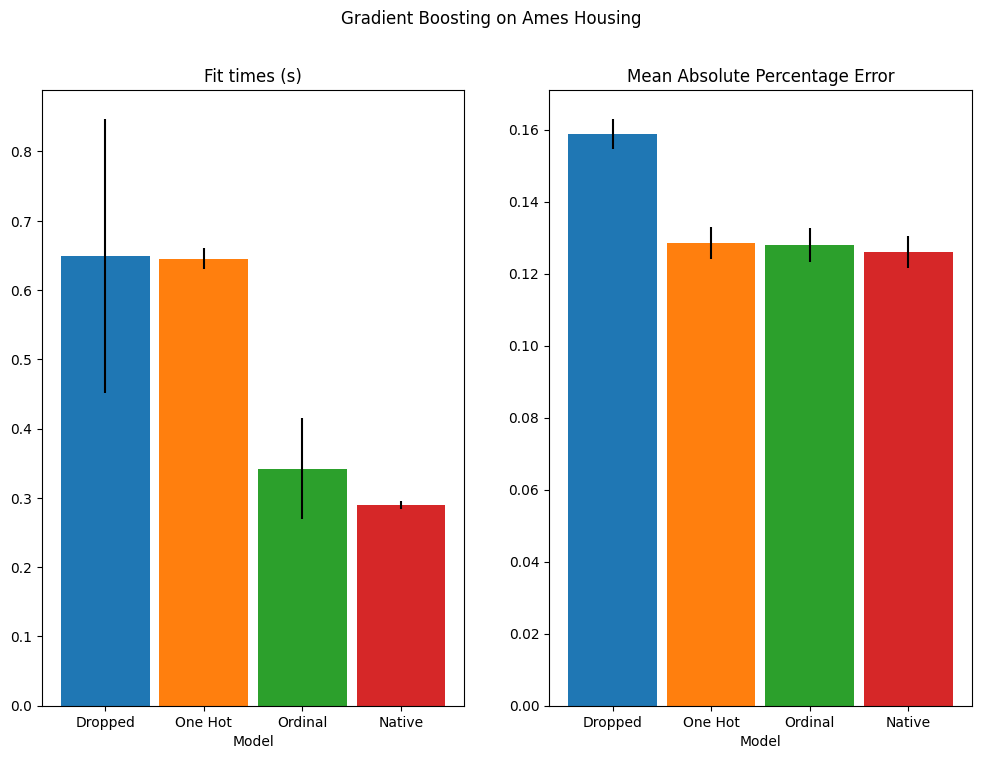

In [23]:
def plot_results(figure_title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    plot_info = [
        ("fit_time", "Fit times (s)", ax1, None),
        ("test_score", "Mean Absolute Percentage Error", ax2, None),
    ]

    x, width = np.arange(4), 0.9
    for key, title, ax, y_limit in plot_info:
        items = [
            dropped_result[key],
            one_hot_result[key],
            ordinal_result[key],
            native_result[key],
        ]

        mape_cv_mean = [np.mean(np.abs(item)) for item in items]
        mape_cv_std = [np.std(item) for item in items]

        ax.bar(
            x=x,
            height=mape_cv_mean,
            width=width,
            yerr=mape_cv_std,
            color=["C0", "C1", "C2", "C3"],
        )
        ax.set(
            xlabel="Model",
            title=title,
            xticks=x,
            xticklabels=["Dropped", "One Hot", "Ordinal", "Native"],
            ylim=y_limit,
        )
    fig.suptitle(figure_title)


plot_results("Gradient Boosting on Ames Housing")

We see that the model with one-hot-encoded data is by far the slowest. This is to be expected, since one-hot-encoding creates one additional feature per category value (for each categorical feature), and thus more split points need to be considered during fitting. In theory, we expect the native handling of categorical features to be slightly slower than treating categories as ordered quantities (‘Ordinal’), since native handling requires sorting categories. Fitting times should however be close when the number of categories is small, and this may not always be reflected in practice.

In terms of prediction performance, dropping the categorical features leads to poorer performance. The three models that use categorical features have comparable error rates, with a slight edge for the native handling.